## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 20 # If you feel too long to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""
Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.4, 0.5, 0.6]
reduce_lr_patient = [5, 10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """
    Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
              )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.40, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 11s 216us/step - loss: 1.1733 - accuracy: 0.5937 - val_loss: 1.4758 - val_accuracy: 0.4775
Epoch 16/20
50000/50000 [==============================] - 11s 221us/step - loss: 1.1509 - accuracy: 0.6037 - val_loss: 1.4627 - val_accuracy: 0.4826
Epoch 17/20
50000/50000 [==============================] - 11s 214us/step - loss: 1.1285 - accuracy: 0.6113 - val_loss: 1.4606 - val_accuracy: 0.4817
Epoch 18/20
50000/50000 [==============================] - 11s 228us/step - loss: 1.1051 - accuracy: 0.6206 - val_loss: 1.4594 - val_accuracy: 0.4861
Epoch 19/20
50000/50000 [==============================] - 12s 234us/step - loss: 1.0814 - accuracy: 0.6296 - val_loss: 1.4745 - val_accuracy: 0.4864
Epoch 20/20
50000/50000 [==============================] - 11s 216us/step - loss: 1.0586 - accuracy: 0.6372 - val_loss: 1.4799 - val_accuracy: 0.4830
Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 5
Model: "model_3"
_____________________________________

50000/50000 [==============================] - 8s 157us/step - loss: 1.3306 - accuracy: 0.5350 - val_loss: 1.5148 - val_accuracy: 0.4626
Epoch 10/20
50000/50000 [==============================] - 8s 163us/step - loss: 1.3014 - accuracy: 0.5485 - val_loss: 1.5078 - val_accuracy: 0.4676
Epoch 11/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.2720 - accuracy: 0.5568 - val_loss: 1.4901 - val_accuracy: 0.4716
Epoch 12/20
50000/50000 [==============================] - 8s 161us/step - loss: 1.2434 - accuracy: 0.5686 - val_loss: 1.4855 - val_accuracy: 0.4754
Epoch 13/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.2179 - accuracy: 0.5771 - val_loss: 1.4782 - val_accuracy: 0.4797
Epoch 14/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.1951 - accuracy: 0.5872 - val_loss: 1.4862 - val_accuracy: 0.4759
Epoch 15/20
50000/50000 [==============================] - 8s 159us/step - loss: 1.1697 - accuracy: 0.5956 - val_loss:

50000/50000 [==============================] - 9s 178us/step - loss: 1.6182 - accuracy: 0.4346 - val_loss: 1.8349 - val_accuracy: 0.3634
Epoch 4/20
50000/50000 [==============================] - 9s 178us/step - loss: 1.5433 - accuracy: 0.4619 - val_loss: 1.7073 - val_accuracy: 0.4123
Epoch 5/20
50000/50000 [==============================] - 9s 181us/step - loss: 1.4862 - accuracy: 0.4802 - val_loss: 1.6380 - val_accuracy: 0.4292
Epoch 6/20
50000/50000 [==============================] - 9s 181us/step - loss: 1.4399 - accuracy: 0.4976 - val_loss: 1.5807 - val_accuracy: 0.4445
Epoch 7/20
50000/50000 [==============================] - 9s 170us/step - loss: 1.3986 - accuracy: 0.5129 - val_loss: 1.5466 - val_accuracy: 0.4621
Epoch 8/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.3625 - accuracy: 0.5272 - val_loss: 1.5188 - val_accuracy: 0.4645
Epoch 9/20
50000/50000 [==============================] - 8s 160us/step - loss: 1.3278 - accuracy: 0.5378 - val_loss: 1.501

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 181us/step - loss: 1.7721 - accuracy: 0.3782 - val_loss: 2.8249 - val_accuracy: 0.2407
Epoch 2/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.5056 - accuracy: 0.4683 - val_loss: 1.8042 - val_accuracy: 0.3557
Epoch 3/20
50000/50000 [==============================] - 9s 186us/step - loss: 1.4100 - accuracy: 0.5010 - val_loss: 1.6360 - val_accuracy: 0.4094
Epoch 4/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.3380 - accuracy: 0.5259 - val_loss: 1.5627 - val_accuracy: 0.4423
Epoch 5/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.2793 - accuracy: 0.5488 - val_loss: 1.5378 - val_accuracy: 0.4480
Epoch 6/20
50000/50000 [==============================] - 9s 183us/step - loss: 1.2226 - accuracy: 0.5687 - val_loss: 1.7133 - val_accuracy: 0.4024
Epoch 7/20
50000/50000 [==============================] - 9s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 185us/step - loss: 1.7561 - accuracy: 0.3910 - val_loss: 3.4789 - val_accuracy: 0.1410
Epoch 2/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.4810 - accuracy: 0.4793 - val_loss: 1.7322 - val_accuracy: 0.3749
Epoch 3/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.3816 - accuracy: 0.5153 - val_loss: 1.6955 - val_accuracy: 0.3884
Epoch 4/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.3089 - accuracy: 0.5389 - val_loss: 1.5863 - val_accuracy: 0.4334
Epoch 5/20
50000/50000 [==============================] - 8s 166us/step - loss: 1.2500 - accuracy: 0.5622 - val_loss: 1.5004 - val_accuracy: 0.4650
Epoch 6/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.1942 - accuracy: 0.5826 - val_loss: 1.4638 - val_accuracy: 0.4796
Epoch 7/20
50000/50000 [==============================] - 9s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 191us/step - loss: 1.7841 - accuracy: 0.3838 - val_loss: 2.7693 - val_accuracy: 0.1946
Epoch 2/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.5023 - accuracy: 0.4738 - val_loss: 1.8920 - val_accuracy: 0.3106
Epoch 3/20
50000/50000 [==============================] - 8s 170us/step - loss: 1.4036 - accuracy: 0.5096 - val_loss: 1.6314 - val_accuracy: 0.4212
Epoch 4/20
50000/50000 [==============================] - 8s 170us/step - loss: 1.3291 - accuracy: 0.5358 - val_loss: 1.5394 - val_accuracy: 0.4577
Epoch 5/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.2712 - accuracy: 0.5561 - val_loss: 1.5525 - val_accuracy: 0.4507
Epoch 6/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.2185 - accuracy: 0.5772 - val_loss: 1.4918 - val_accuracy: 0.4692
Epoch 7/20
50000/50000 [==============================] - 8s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.7839 - accuracy: 0.3872 - val_loss: 2.1342 - val_accuracy: 0.2143
Epoch 2/20
50000/50000 [==============================] - 8s 169us/step - loss: 1.5168 - accuracy: 0.4679 - val_loss: 1.9079 - val_accuracy: 0.2925
Epoch 3/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.4129 - accuracy: 0.5056 - val_loss: 2.0784 - val_accuracy: 0.2719
Epoch 4/20
50000/50000 [==============================] - 8s 170us/step - loss: 1.3416 - accuracy: 0.5306 - val_loss: 1.8015 - val_accuracy: 0.3604
Epoch 5/20
50000/50000 [==============================] - 8s 169us/step - loss: 1.2791 - accuracy: 0.5537 - val_loss: 1.6913 - val_accuracy: 0.4040
Epoch 6/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.2251 - accuracy: 0.5734 - val_loss: 1.8595 - val_accuracy: 0.3546
Epoch 7/20
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 197us/step - loss: 2.1516 - accuracy: 0.2793 - val_loss: 2.1199 - val_accuracy: 0.2246
Epoch 2/20
50000/50000 [==============================] - 9s 172us/step - loss: 1.7894 - accuracy: 0.3830 - val_loss: 1.9771 - val_accuracy: 0.3074
Epoch 3/20
50000/50000 [==============================] - 9s 172us/step - loss: 1.6616 - accuracy: 0.4235 - val_loss: 1.8539 - val_accuracy: 0.3567
Epoch 4/20
50000/50000 [==============================] - 9s 172us/step - loss: 1.5787 - accuracy: 0.4536 - val_loss: 1.7451 - val_accuracy: 0.3881
Epoch 5/20
50000/50000 [==============================] - 9s 173us/step - loss: 1.5186 - accuracy: 0.4730 - val_loss: 1.6807 - val_accuracy: 0.4168
Epoch 6/20
50000/50000 [==============================] - 9s 173us/step - loss: 1.4685 - accuracy: 0.4910 - val_loss: 1.6309 - val_accuracy: 0.4214
Epoch 7/20
50000/50000 [==============================] - 9s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1946 - accuracy: 0.2742 - val_loss: 2.1587 - val_accuracy: 0.2265
Epoch 2/20
50000/50000 [==============================] - 9s 182us/step - loss: 1.8141 - accuracy: 0.3760 - val_loss: 2.0305 - val_accuracy: 0.2881
Epoch 3/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.6791 - accuracy: 0.4165 - val_loss: 1.8899 - val_accuracy: 0.3566
Epoch 4/20
50000/50000 [==============================] - 9s 181us/step - loss: 1.5942 - accuracy: 0.4457 - val_loss: 1.7665 - val_accuracy: 0.3965
Epoch 5/20
50000/50000 [==============================] - 9s 180us/step - loss: 1.5296 - accuracy: 0.4673 - val_loss: 1.6926 - val_accuracy: 0.4095
Epoch 6/20
50000/50000 [==============================] - 9s 187us/step - loss: 1.4775 - accuracy: 0.4860 - val_loss: 1.6146 - val_accuracy: 0.4393
Epoch 7/20
50000/50000 [==============================] - 9s 

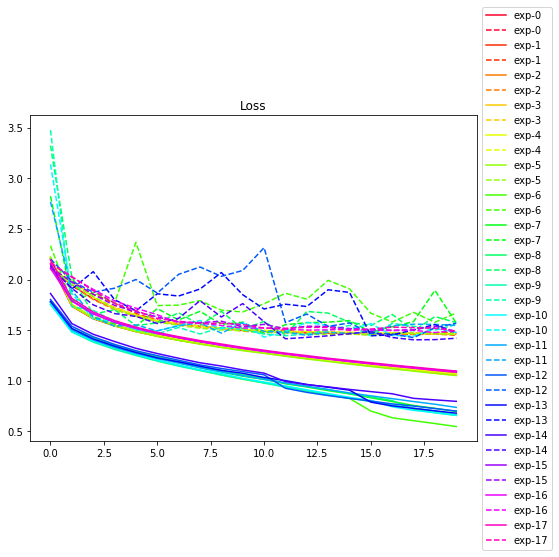

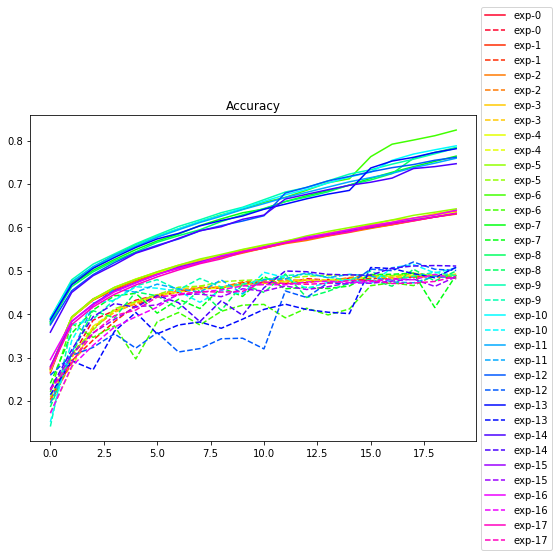

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()